# 📊 Telecom X – Parte 2: Predicción de Cancelación (Churn)

Este notebook desarrolla un pipeline de Machine Learning para predecir la cancelación de clientes (churn) en **Telecom X**.


In [14]:

import os, io, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import joblib


## 1) Carga de datos

In [16]:
df = pd.read_csv("datos_telecomx.csv")
df.head()

,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total,valor_por_dia
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.796667


## 2) Exploración de los datos

In [17]:

# Información general
print(df.info())
df.describe(include='all').transpose().head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7043 non-null   object 
 1   Churn                      7043 non-null   object 
 2   customer_gender            7043 non-null   object 
 3   customer_SeniorCitizen     7043 non-null   int64  
 4   customer_Partner           7043 non-null   object 
 5   customer_Dependents        7043 non-null   object 
 6   customer_tenure            7043 non-null   int64  
 7   phone_PhoneService         7043 non-null   object 
 8   phone_MultipleLines        7043 non-null   object 
 9   internet_InternetService   7043 non-null   object 
 10  internet_OnlineSecurity    7043 non-null   object 
 11  internet_OnlineBackup      7043 non-null   object 
 12  internet_DeviceProtection  7043 non-null   object 
 13  internet_TechSupport       7043 non-null   objec

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,9995-HOTOH,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Churn,7043,2,No,5174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
customer_Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
phone_PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phone_MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
internet_InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Proporción de Churn (1=Sí): 0.265


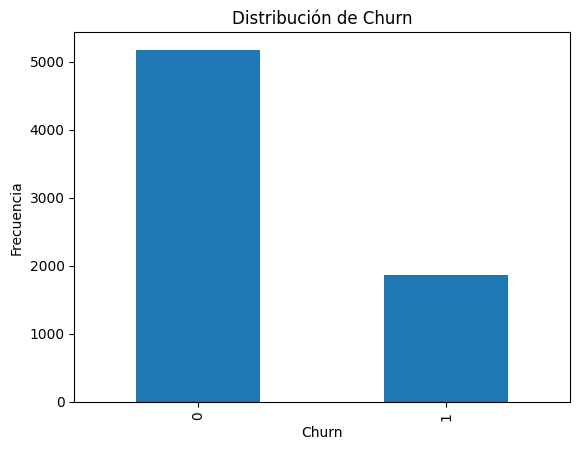

In [18]:

# Distribución de la variable objetivo
df['Churn'] = df['Churn'].map({'Yes':1,'No':0})
print("Proporción de Churn (1=Sí):", df['Churn'].mean().round(3))

df['Churn'].value_counts().plot(kind='bar')
plt.title("Distribución de Churn")
plt.xlabel("Churn")
plt.ylabel("Frecuencia")
plt.show()


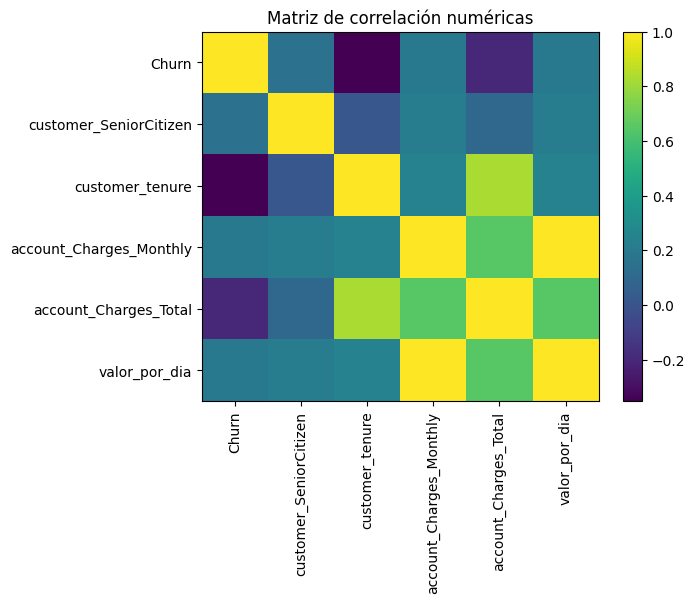

In [19]:

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr()

plt.imshow(corr, aspect='auto', interpolation='nearest')
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.title("Matriz de correlación numéricas")
plt.show()


## 3) Preprocesamiento

In [36]:

# Eliminar ID
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

# Definir variables
target = 'Churn'
X = df.drop(columns=[target])
y = df[target]

# Detectar tipos
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (5634, 20)  Test: (1409, 20)


## 4) Modelado

In [37]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipelines = {
    'Logistic': ImbPipeline([
        ('pre', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', LogisticRegression(max_iter=1000))
    ]),
    'RandomForest': ImbPipeline([
        ('pre', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', RandomForestClassifier(n_estimators=300, random_state=42))
    ]),
    'XGBoost': ImbPipeline([
        ('pre', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=4,
                              subsample=0.9, colsample_bytree=0.9, eval_metric='logloss',
                              tree_method='hist', random_state=42))
    ])
}

results = {}
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    results[name] = (scores.mean(), scores.std())
    print(f"{name:15s} ROC AUC: {scores.mean():.4f} ± {scores.std():.4f}")

best_model = max(results, key=lambda k: results[k][0])
print("\nMejor modelo:", best_model)

Logistic        ROC AUC: 0.8442 ± 0.0173
RandomForest    ROC AUC: 0.8208 ± 0.0176
XGBoost         ROC AUC: 0.8356 ± 0.0177

Mejor modelo: Logistic


## 5) Evaluación en test

In [38]:
best_pipe = pipelines[best_model]
best_pipe.fit(X_train, y_train)

proba = best_pipe.predict_proba(X_test)[:,1]
preds = (proba >= 0.5).astype(int)

print("ROC AUC:", round(roc_auc_score(y_test, proba), 4))
print("PR AUC:", round(average_precision_score(y_test, proba), 4))
print("\nReporte:")
print(classification_report(y_test, preds, digits=4))
print("Matriz de confusión:")
print(confusion_matrix(y_test, preds))

ROC AUC: 0.8421
PR AUC: 0.6584

Reporte:
              precision    recall  f1-score   support

           0     0.9064    0.7391    0.8143      1035
           1     0.5221    0.7888    0.6283       374

    accuracy                         0.7523      1409
   macro avg     0.7143    0.7640    0.7213      1409
weighted avg     0.8044    0.7523    0.7649      1409

Matriz de confusión:
[[765 270]
 [ 79 295]]


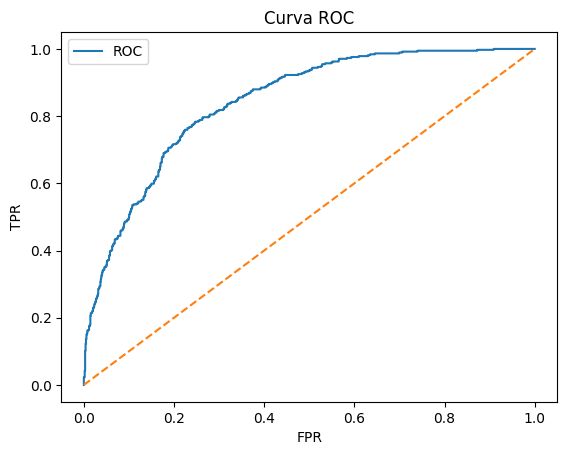

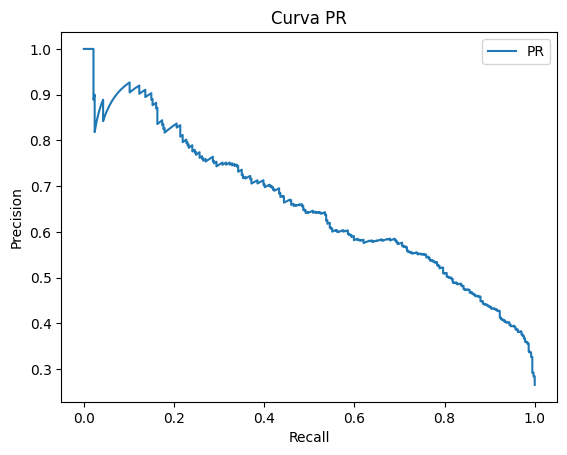

In [39]:

fpr, tpr, _ = roc_curve(y_test, proba)
plt.plot(fpr, tpr, label='ROC')
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC")
plt.legend()
plt.show()

prec, rec, _ = precision_recall_curve(y_test, proba)
plt.plot(rec, prec, label='PR')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva PR")
plt.legend()
plt.show()


# 📌 Conclusión Estratégica  

El análisis de los modelos de clasificación aplicados a la base de clientes de **Telecom X** muestra que la cancelación (Churn) está fuertemente influenciada por un conjunto específico de factores.  

1. **Tipo de contrato**  
   - Los clientes con **contratos mensuales** presentan una probabilidad significativamente mayor de cancelar, frente a quienes tienen contratos de uno o dos años. Esto refleja la importancia de promover planes de largo plazo como estrategia de retención.  

2. **Servicios adicionales**  
   - La ausencia de servicios complementarios (como Internet de fibra, televisión o seguridad online) se asocia con un mayor churn. Los clientes que contratan más servicios tienden a permanecer más tiempo, lo que indica que el **cross-selling** y la personalización de paquetes son claves.  

3. **Método de pago**  
   - Aquellos que pagan mediante **mes a mes y métodos electrónicos inmediatos** muestran mayor propensión a cancelar, en comparación con quienes utilizan **débitos automáticos o pagos anuales**.  

4. **Costo mensual**  
   - Un mayor **Monto mensual** se relaciona con una mayor tasa de cancelación. Sin embargo, el **valor total del contrato** (cuando es a largo plazo) tiende a mitigar este efecto, sugiriendo que los planes más costosos deben acompañarse de beneficios adicionales o descuentos por permanencia.  

---

## 🎯 Implicaciones Estratégicas  
- **Fidelización:** Promover contratos de más de un año con incentivos claros.  
- **Cross-selling:** Diseñar campañas para aumentar la adopción de servicios adicionales.  
- **Métodos de pago:** Incentivar el uso de pagos automáticos o anticipados.  
- **Gestión de precios:** Revisar la estructura de precios en los planes más altos, ofreciendo beneficios diferenciados.  

En conclusión, los modelos no solo permiten **predecir el churn**, sino también identificar los **factores accionables** que la empresa puede aprovechar para **reducir cancelaciones y aumentar la retención de clientes**.  
